In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

import torchvision
from torchvision.transforms import ToTensor
from torchvision.datasets import LFWPairs
from torchvision import transforms
import time
import torch.optim.lr_scheduler as lr_scheduler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Creating a Dataset Object:

In [18]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((105,105)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_set = LFWPairs(root="", split="train", download=True, transform=transform)

# Split the training set into train and validation sets
total_samples = len(train_set)
train_size = int(0.9 * total_samples)
val_size = total_samples - train_size

train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# Load the test set
test_set = LFWPairs(root="", split="test", download=True, transform=transform)

100%|██████████| 243346528/243346528 [03:16<00:00, 1237007.55it/s]


Extracting lfw-py/lfw-funneled.tgz to lfw-py


100%|██████████| 56579/56579 [00:00<00:00, 351276.68it/s]


Using downloaded and verified file: lfw-py/lfw-funneled.tgz
Extracting lfw-py/lfw-funneled.tgz to lfw-py


100%|██████████| 26002/26002 [00:00<00:00, 331575.92it/s]


# 2. Creating the DataLoaders:

In [19]:
train_dataloader = torch.utils.data.DataLoader(train_set,
                                          batch_size=64,
                                          shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set,
                                          batch_size=64,
                                          shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set,
                                          batch_size=64,
                                          shuffle=True)

# EDA on the Data:

In [16]:
print(f"Num train dataloaders:{len(train_dataloader)}")
print(f"Num val dataloaders:{len(val_dataloader)}")
print(f"Num test dataloaders:{len(test_dataloader)}")

Num train dataloaders:31
Num val dataloaders:4
Num test dataloaders:16


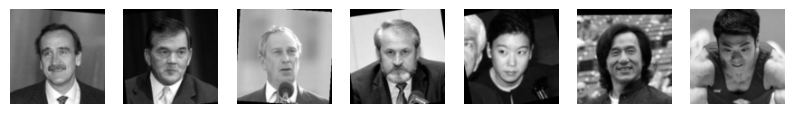

In [17]:
# Assuming train_dataset is a Subset object containing images
def show_images_from_subset(subset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))
    for i in range(num_images):
        # Get the image from the subset
        image = subset[i][0]  # Assuming each item in the subset is a tuple (image, label)
        # Plot the image
        axes[i].imshow(image.squeeze().cpu().numpy(), cmap='gray')
        axes[i].axis('off')  # Remove axes
    plt.show()

show_images_from_subset(train_set, num_images=7)

In [18]:
def calculate_unique_names(file_path, end_row):
    unique_names = set()
    
    with open(file_path, 'r') as file:
        for _ in range(end_row):
            line = next(file)
            parts = line.strip().split('\t')
            name = parts[0]
            unique_names.add(name)
            if _ == end_row - 1:
                break

    return unique_names

def calculate_unique_names_from_middle(file_path, start_row):
    unique_names = set()

    with open(file_path, 'r') as file:
        for _ in range(start_row):
            next(file)  # Skip rows until you reach the desired row
        
        # Process rows starting from the desired row
        for line in file:
            parts = line.strip().split('\t')
            name1 = parts[0]
            name2 = parts[2]
            unique_names.add(name1)
            unique_names.add(name2)

    return unique_names

train_txt = "/kaggle/working/lfw-py/pairsDevTrain.txt"
start_row = 1102  # Start from row 1102 (including row 1102)
unique_names_starting_row_1102 = calculate_unique_names_from_middle(train_txt, start_row)

train_txt = "/kaggle/working/lfw-py/pairsDevTrain.txt"
end_row = 1102  # Calculate until row 1101 (including row 1101)
unique_names = calculate_unique_names(train_txt, end_row)

unique_names_count = len(set(unique_names)|set(unique_names_starting_row_1102))

print("Unique Names Count in train:", unique_names_count)

Unique Names Count in train: 2132


In [19]:
test_txt = "/kaggle/working/lfw-py/pairsDevTest.txt"
start_row = 502  # Start from row 1102 (including row 1102)
unique_names_starting_row_502 = calculate_unique_names_from_middle(test_txt, start_row)

train_txt = "/kaggle/working/lfw-py/pairsDevTest.txt"
end_row = 502  # Calculate until row 1101 (including row 1101)
unique_names = calculate_unique_names(test_txt, end_row)

unique_names_count = len(set(unique_names)|set(unique_names_starting_row_502))

print("Unique Names Count in test:", unique_names_count)

Unique Names Count in test: 963


In [20]:
def get_num_examples(dataset,j=0):
    names_dict = set()
    names_number = 0
    correct = 0
    if j==0:
        print(f"Pairs in train dataset:{len(dataset)}")
    if j==1:
        print(f"Pairs in validation dataset:{len(dataset)}")
    if j==2:
        print(f"Pairs in test dataset:{len(dataset)}")
    for name1, name2, l in dataset:
        if l==1:
            correct+=1
            names_dict.add(name1)
        if l==0:
            # Add names to the sets
            names_dict.add(name1)
            names_dict.add(name2)
    names_number = len(names_dict)
    print(f"Correct Pairs are:{correct}")   
    return names_dict

In [21]:
train_name_number = get_num_examples(train_set,j=0)
val_name_number = get_num_examples(val_set,j=1)
test_name_number = get_num_examples(test_set,j=2)
print(f'Total people in dataset: {len(set(train_name_number) | set(test_name_number) | set(val_name_number))}')
print(f'Total people train: {len(train_name_number)}')
print(f'Total people test: {len(test_name_number)}')

Pairs in train dataset:1980
Correct Pairs are:985
Pairs in validation dataset:220
Correct Pairs are:115
Pairs in test dataset:1000
Correct Pairs are:500
Total people in dataset: 4800
Total people train: 2975
Total people test: 1500


# 3. Creating the Model Class:

In [12]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,i):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.relu = nn.ReLU()
        if i!=7:
            self.max_pool = nn.MaxPool2d(2, 2)
        self.batch = nn.BatchNorm2d(out_channels)
        self.drop = nn.Dropout(0.7)
        self.i = i

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        if self.i!=7:
            x = self.max_pool(x)
        x = self.batch(x)
        x = self.drop(x)
        return x

In [13]:
class Siamese_Model(nn.Module):
    def __init__(self, kernel_size=10,reduce=False):
        super(Siamese_Model, self).__init__()

        blocks = [CNNBlock(1, 32, kernel_size,0)]
        for i in range(6, 8):
            for j in {3,6}:
                if i==6 and j==3:
                    if reduce:
                        blocks += [CNNBlock(2**(i-1), 2**(i-1), kernel_size-j,i)]
                    else:
                        blocks += [CNNBlock(2**(i-1), 2**(i), kernel_size-j,i)]
                if i==6 and j==6:
                    if reduce:
                        blocks += [CNNBlock(2**(i-1), 2**(i-1), kernel_size-j,i)]
                    else:
                        blocks += [CNNBlock(2**(i), 2**(i), kernel_size-j,i)]
                if i==7 and j==6:
                    if reduce:
                        blocks += [CNNBlock(2**(i-2), 2**(i-2), kernel_size-j,i)]
                    else:
                        blocks += [CNNBlock(2**(i-1), 2**(i), kernel_size-j,i)]

        self.layers = nn.ModuleList(blocks)
        if reduce:
            l = 32 * 6 * 6
            r = 32
        else:
            l = 128 * 6 * 6
            r = 4096
        self.linear1 = nn.Sequential(
            nn.Linear(l, r),
            nn.Sigmoid())

        self.linear2 = nn.Sequential(nn.Linear(r, 1),nn.Sigmoid())

    def forward(self, x, y):

        for block in self.layers:
            x = block(x)
        x = x.view(x.size(0), -1)
        x = self.linear1(x)

        for block in self.layers:
            y = block(y)
        y = y.view(y.size(0), -1)
        y = self.linear1(y)

        final = self.linear2(torch.abs(x - y))

        return final

@torch.no_grad()
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.01)
        if m.bias is not None:
              torch.nn.init.normal_(m.bias, mean=0.5, std=0.01)
    elif isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.01)
        if m.bias is not None:
            torch.nn.init.normal_(m.bias, mean=0.0, std=0.01)


# 4. Creating the model, optimizer and loss function objects:

In [15]:
model = Siamese_Model(reduce=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

#Binary Cross Entropy:
criterion = torch.nn.BCELoss()

#decreasing the learning rate factor by 1% after each epoch:
lmbda = lambda epoch: 0.99
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

In [16]:
model.parameters

<bound method Module.parameters of Siamese_Model(
  (layers): ModuleList(
    (0): CNNBlock(
      (conv): Conv2d(1, 32, kernel_size=(10, 10), stride=(1, 1))
      (relu): ReLU()
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (batch): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop): Dropout(p=0.7, inplace=False)
    )
    (1): CNNBlock(
      (conv): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1))
      (relu): ReLU()
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (batch): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop): Dropout(p=0.7, inplace=False)
    )
    (2): CNNBlock(
      (conv): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
      (relu): ReLU()
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (batch): BatchNorm2d(32, eps=1e-05, mo

# 5. Training the model with a pytorch training loop:

In [20]:
next(iter(train_dataloader))[2]

tensor([0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [21]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, Y, label) in enumerate(dataloader):
        X, Y, label = X.to(device), Y.to(device), label.to(device)

        # Compute prediction error
        pred = model(X,Y)
        loss = loss_fn(pred.float(), label.unsqueeze(1).float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), batch * len(X)

In [22]:
def threashold_sigmoid(thr):
    """prob > 0.5 --> 1 else 0"""
    th = thr.clone()
    th.data.fill_(0.5)
    return (thr > th).float()

In [23]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad(): 
        for X, Y, label in dataloader:
            X, Y, label = X.to(device), Y.to(device), label.to(device)
            pred = model(X,Y)
            test_loss += loss_fn(pred.float(), label.unsqueeze(1).float()).item()
            pred = torch.flatten(pred)
            output_labels = threashold_sigmoid(pred)
            correct += (output_labels == label).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return {"Accuracy":correct,"Avg loss": test_loss}

In [24]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
epochs = []
EPOCH = 50
t1 = time.time()
for epoch in range(EPOCH):
    if epoch==0:
        model.apply(init_weights)
    #train of each epoch:
    epoch_loss = train(train_dataloader, model, criterion, optimizer)
    #save the results of each epoch
    epochs.append(epoch)
    metrics_train = test(train_dataloader, model, criterion)
    train_loss.append(metrics_train["Avg loss"])
    train_acc.append(float(metrics_train["Accuracy"]))
    metrics_val = test(val_dataloader, model, criterion)
    val_loss.append(metrics_val["Avg loss"])
    val_acc.append(float(metrics_val["Accuracy"]))
    print(f'Epoch: {epoch}, Validation Loss: {metrics_val["Avg loss"]}, Validation Accuracy: {metrics_val["Accuracy"]}, Train_loss: {metrics_train["Avg loss"]}')

    # Early_stopping needs the validation loss to check if it has decresed,
    # and if it has, it will make a checkpoint of the current model
    if len(train_loss)>=10:
        if abs(val_loss[-1]-val_loss[-2])<0.0001 or abs(val_loss[-1]-val_loss[-2])>0.1:
            print("Early stopping")
            break
t2 = time.time()
print("Total time (sec): "+str(t2-t1))
print("Done!")

Epoch: 0, Validation Loss: 0.6933588981628418, Validation Accuracy: 0.4954545454545455, Train_loss: 0.6930427493587616
Epoch: 1, Validation Loss: 0.6918001174926758, Validation Accuracy: 0.4863636363636364, Train_loss: 0.6900965686767332
Epoch: 2, Validation Loss: 0.6950494349002838, Validation Accuracy: 0.5454545454545454, Train_loss: 0.687271818037956
Epoch: 3, Validation Loss: 0.6894197314977646, Validation Accuracy: 0.55, Train_loss: 0.6822907309378347
Epoch: 4, Validation Loss: 0.6670588403940201, Validation Accuracy: 0.5863636363636363, Train_loss: 0.6686688776939146
Epoch: 5, Validation Loss: 0.6576017588376999, Validation Accuracy: 0.6272727272727273, Train_loss: 0.6547634428547274
Epoch: 6, Validation Loss: 0.6558074355125427, Validation Accuracy: 0.6090909090909091, Train_loss: 0.6491080061081917
Epoch: 7, Validation Loss: 0.6308374851942062, Validation Accuracy: 0.6272727272727273, Train_loss: 0.636226886703122
Epoch: 8, Validation Loss: 0.6541977673768997, Validation Accura

# 6. Testing the model:

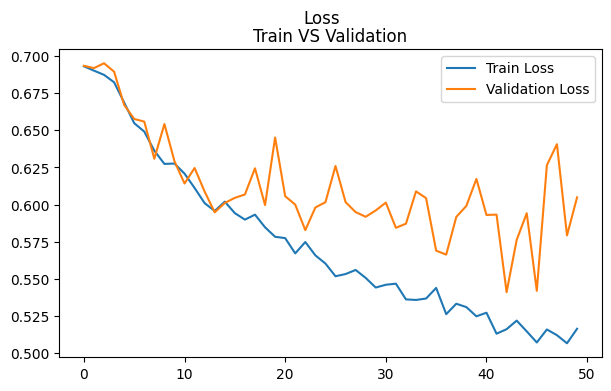

In [25]:
plt.figure(figsize=(7,4), dpi=100)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs,val_loss, label="Validation Loss")
plt.legend(loc='best', fontsize=10)
plt.title("Train VS Validation")
plt.suptitle("Loss")
plt.show()

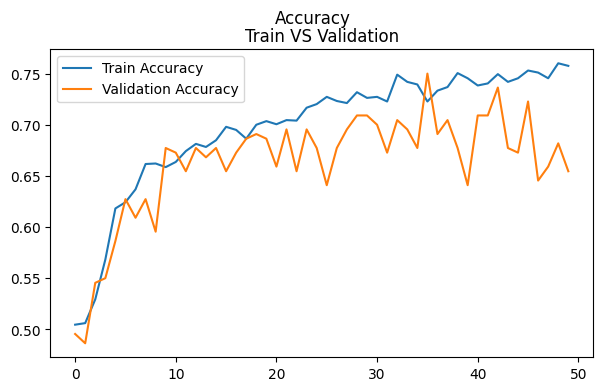

In [26]:
plt.figure(figsize=(7,4), dpi=100)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs,val_acc, label="Validation Accuracy")
plt.legend(loc='best', fontsize=10)
plt.title("Train VS Validation")
plt.suptitle("Accuracy")
plt.show()

In [27]:
metrics = test(test_dataloader,model, criterion)
print(f'Test Loss: {metrics["Avg loss"]} Test Accuracy: {metrics["Accuracy"]}')

Test Loss: 0.6325359418988228 Test Accuracy: 0.655


# 7. Examples of accurate and misclassifications:

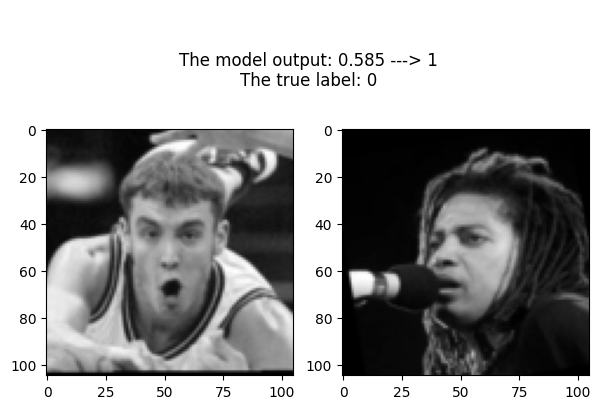

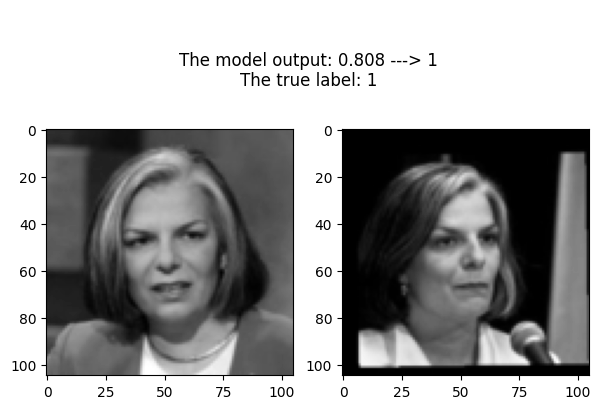

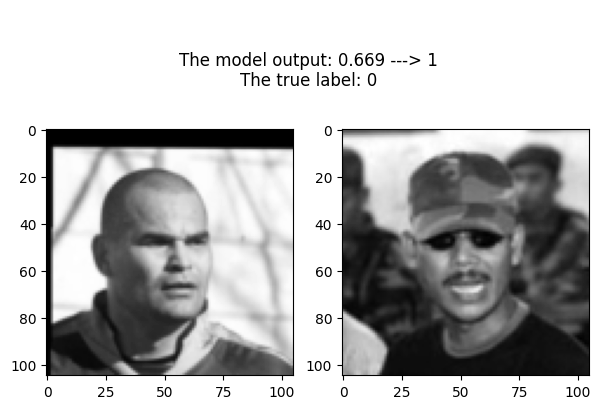

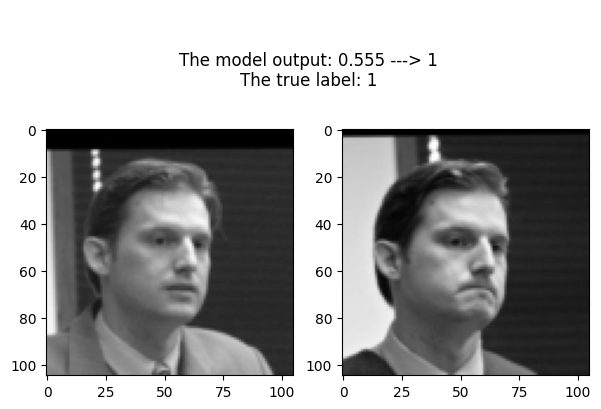

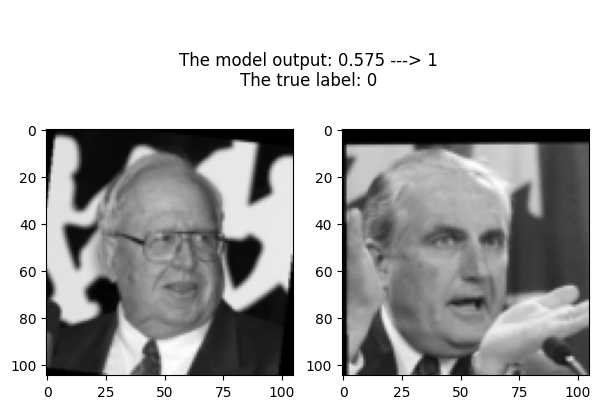

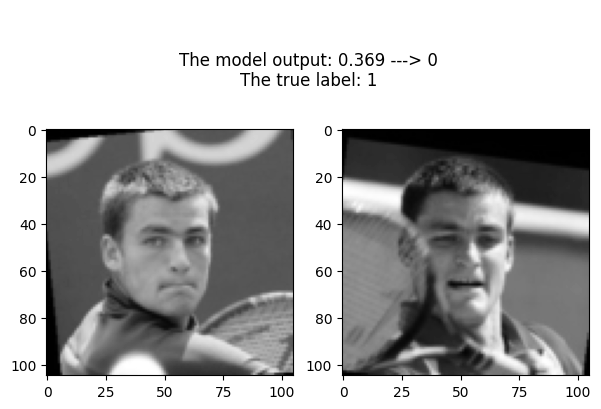

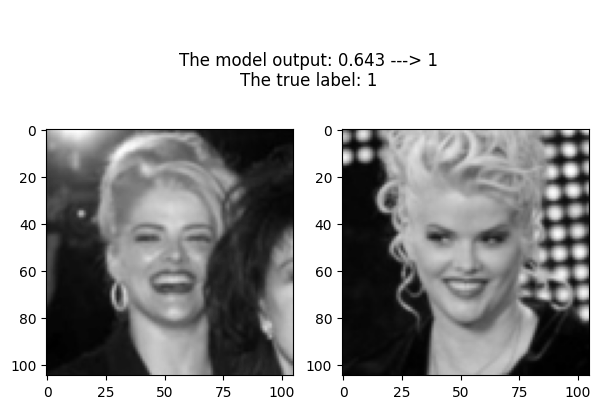

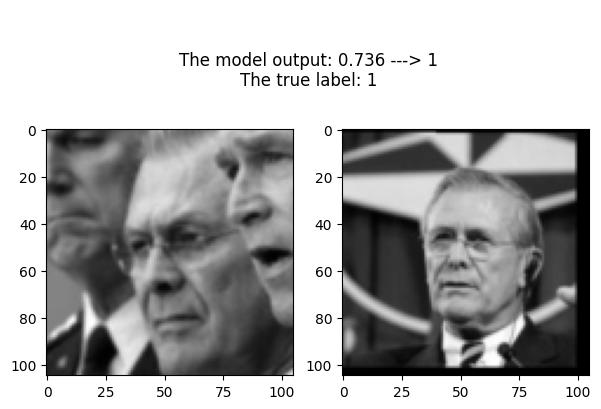

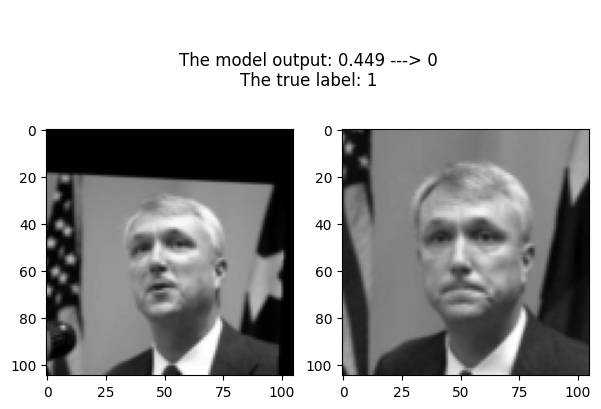

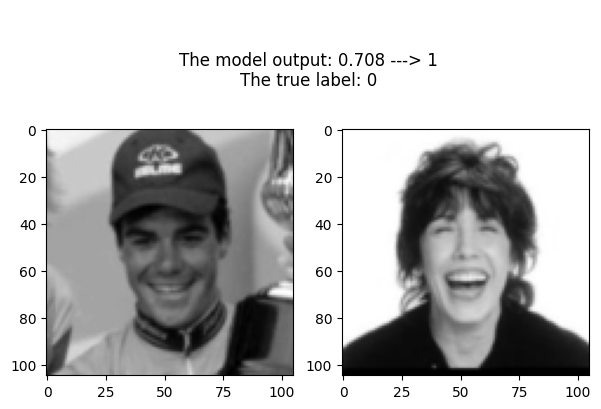

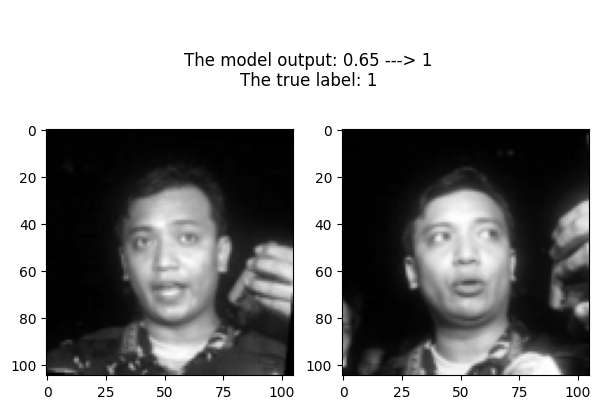

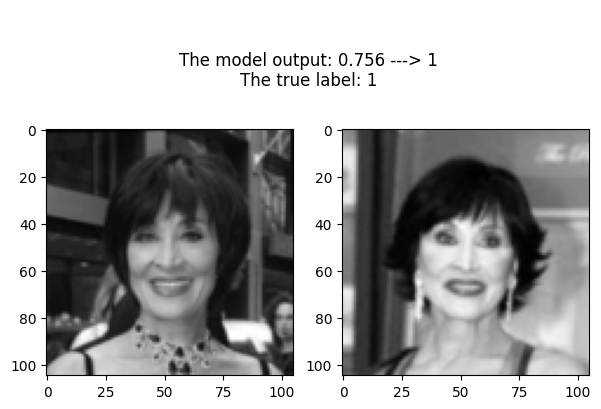

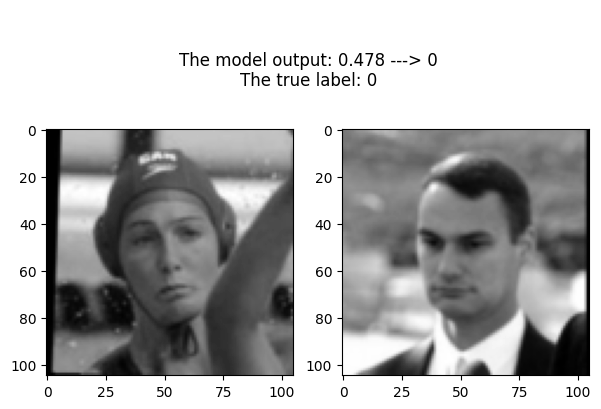

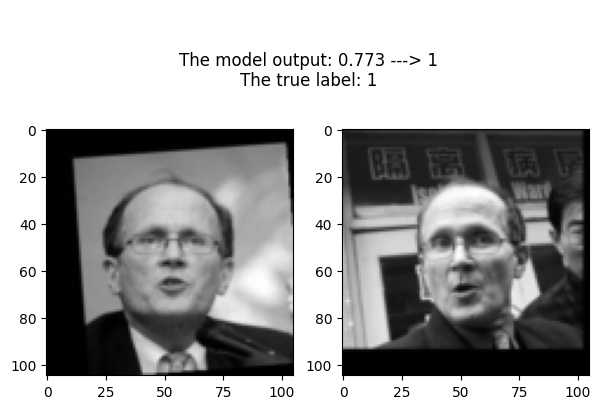

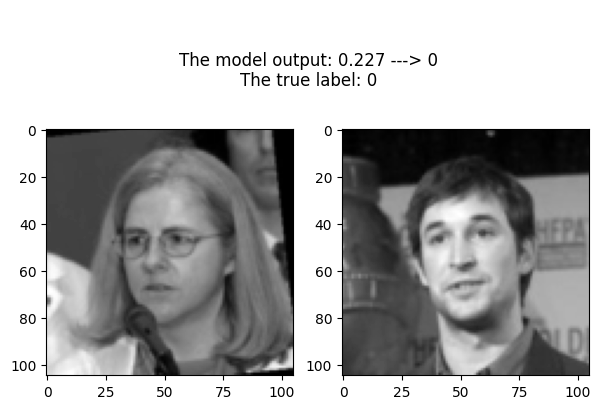

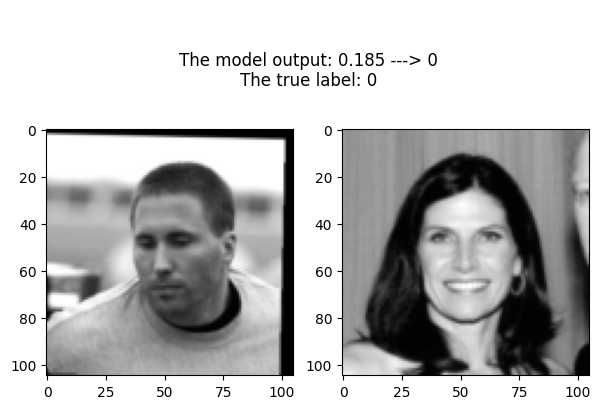

In [28]:
for i, (img1, img2, label) in enumerate(test_dataloader):
    img1, img2, label = img1.to(device), img2.to(device), label.to(device)
    im1 = img1[0].cpu().numpy()
    im2 = img2[0].cpu().numpy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(7, 5)
    ax1.imshow(im1[0], cmap='gray')
    ax2.imshow(im2[0], cmap='gray')
    
    pred = model(img1, img2)
    p = round(float(pred[0]), 3)
    c = 1 if p > 0.5 else 0
    
    fig.suptitle("\n\nThe model output: {} ---> {}\nThe true label: {}".format(p, c, int(label[0])))
    
    if i == 20:
        break